In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = { 'pandas','numpy', 'matplotlib', 'seaborn','toad','pickle','sklearn'}
missing = required - installedPackages
print(missing)
# if missing:
#     !pip install pandas
#     !pip install numpy
#     !pip install matplotlib
#     !pip install seaborn
#     !pip install toad
#     !pip install pickle
#     !pip install sklearn

{'pickle', 'sklearn'}


In [2]:
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,roc_curve,auc,precision_recall_curve

import math
import glob
import toad
import pickle
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [3]:
sns.set()

# 1. Data Preprocessing

In [4]:
def data_split(df, start, end, date_col):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[date_col] >= start) & (df[date_col] < end)]
    #data = df[(df.order_date >= start) & (df.order_date < end)]
    data = data.reset_index(drop=True)
    #data = data.sort_values(["date", "tic"], ignore_index=True)
    #data.index = data.date.factorize()[0]
    return data


def target_info(df_target_column):
    '''
    Print target column information -- count for each unique values in target column
    Input: target column in dataframe
    '''
    proportion_true=str(round(sum(df_target_column == True) / len(df_target_column), 2) * 100)
    
    proportion_false=str(round(sum(df_target_column == False) / len(df_target_column), 3) * 100)
    
    print('There are total {} records in our data.'.format(len(df_target_column)))
    print('Is Fraud:')
    print('Count: {}'.format(sum(df_target_column == True)))
    print('Proportion (Fraud): {}'.format(proportion_true
                                  + '%'))
    print('Not Fraud:')
    print('Count: {}'.format(sum(df_target_column == False)))
    print('Proportion (Not Fraud): {}'.format(proportion_false
                                  + '%'))
    plt.figure(figsize=(5, 5))
    sns.barplot(x=df_target_column.value_counts().index, y=df_target_column.value_counts())
    plt.title('Not Fraud vs Fraud Counts')
    plt.ylabel('Count')
    return proportion_true



In [5]:
# use pandas to load the csv file
data = pd.read_csv('UCI_Credit_Card.csv')

# check few lines
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
# check the size of the data
data.shape

(30000, 25)

In [7]:
#use the word 'label'
data['label'] = data['default.payment.next.month']
data=data.drop(columns=['default.payment.next.month'])

There are total 30000 records in our data.
Is Fraud:
Count: 6636
Proportion (Fraud): 22.0%
Not Fraud:
Count: 23364
Proportion (Not Fraud): 77.9%


'22.0'

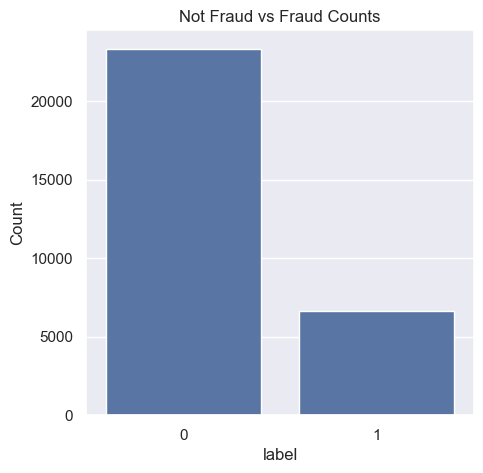

In [8]:
#check the fraud proportion of the data
target_info(data['label'])

In [9]:
# set an exclude list for the scorecard package Toad
exclude_list = ['ID','label']

In [10]:
data.ID.describe()

count    30000.000000
mean     15000.500000
std       8660.398374
min          1.000000
25%       7500.750000
50%      15000.500000
75%      22500.250000
max      30000.000000
Name: ID, dtype: float64

In [11]:
# use the ID column to split the train-test data
train = data_split(data,start = 0, end=22500,date_col='ID')
test = data_split(data,start = 22500, end=172792,date_col='ID')

In [12]:
train.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [13]:
test.label.value_counts()

label
0    5953
1    1548
Name: count, dtype: int64

In [14]:
# EDA functions
toad.detect(train)

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
ID,int64,22499,0.00%,22499,11250.000000,6495.046189,1.0,225.98,2250.8,11250.0,16874.5,20249.2,22274.02,22499.0
LIMIT_BAL,float64,22499,0.00%,77,163413.204142,128506.717166,10000.0,10000.00,30000.0,130000.0,230000.0,360000.0,500000.00,1000000.0
SEX,int64,22499,0.00%,2,1.610160,0.487725,1.0,1.00,1.0,2.0,2.0,2.0,2.00,2.0
EDUCATION,int64,22499,0.00%,7,1.840660,0.775198,0.0,1.00,1.0,2.0,2.0,3.0,4.00,6.0
MARRIAGE,int64,22499,0.00%,4,1.564158,0.521309,0.0,1.00,1.0,2.0,2.0,2.0,3.00,3.0
AGE,int64,22499,0.00%,55,35.212809,9.307465,21.0,22.00,25.0,33.0,41.0,49.0,60.00,79.0
PAY_0,int64,22499,0.00%,11,0.015067,1.119849,-2.0,-2.00,-1.0,0.0,0.0,2.0,3.00,8.0
PAY_2,int64,22499,0.00%,11,-0.106983,1.197151,-2.0,-2.00,-2.0,0.0,0.0,2.0,3.00,8.0
PAY_3,int64,22499,0.00%,11,-0.137428,1.202663,-2.0,-2.00,-2.0,0.0,0.0,2.0,3.00,8.0
PAY_4,int64,22499,0.00%,11,-0.197298,1.164358,-2.0,-2.00,-2.0,0.0,0.0,2.0,3.00,8.0


# 2. Feature Filtering

In [15]:
chi, p, dof, ex = chi2_contingency(pd.crosstab(train['label'], pd.Categorical(train['EDUCATION'])))
chi2_contingency(pd.crosstab(train['label'], pd.Categorical(train['EDUCATION'])))

Chi2ContingencyResult(statistic=118.98711360925743, pvalue=2.659398848545355e-23, dof=6, expected_freq=array([[7.73856616e+00, 6.17692351e+03, 8.22841740e+03, 2.77118054e+03,
        5.88131028e+01, 1.42389617e+02, 2.55372683e+01],
       [2.26143384e+00, 1.80507649e+03, 2.40458260e+03, 8.09819459e+02,
        1.71868972e+01, 4.16103827e+01, 7.46273168e+00]]))

In [16]:
F_statistic, p_values = f_classif(train[['BILL_AMT1']], train['label'])
f_classif(train[['BILL_AMT1']], train['label'])

(array([11.46319864]), array([0.00071109]))

In [17]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the IV is smaller than the threshold, delete the features
train_selected, drop_lst= toad.selection.select(frame = train,
                                                target=train['label'], 
                                                empty = 0.5, 
                                                iv = 0.05, corr = 0.7, 
                                                return_drop=True, 
                                                exclude=exclude_list)

print("keep:",train_selected.shape[1],
      ", drop empty:",len(drop_lst['empty']),
      ", drop iv:",len(drop_lst['iv']),
      ", drop corr:",len(drop_lst['corr']))

keep: 12 , drop empty: 0 , drop iv: 10 , drop corr: 3


In [18]:
drop_lst

{'empty': array([], dtype=float64),
 'iv': array(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'], dtype=object),
 'corr': array(['PAY_4', 'PAY_6', 'PAY_3'], dtype=object)}

In [19]:
# output the iv table to a dataframe
pd.DataFrame.iteritems = pd.DataFrame.items
def output_iv_importance(train_selected,label_col):
    feat_import_iv = toad.quality(train_selected,label_col,iv_only=True)
    feat_import_iv=feat_import_iv['iv']
    feat_import_iv = feat_import_iv.reset_index()
    feat_import_iv.columns = ['name','iv']
    return feat_import_iv
df_iv=output_iv_importance(train_selected,'label')

In [20]:
df_iv.shape

(11, 2)

In [21]:
df_iv.head(30)

,name,iv
0,PAY_0,0.864707
1,PAY_2,0.536068
2,PAY_5,0.340014
3,PAY_AMT1,0.189334
4,LIMIT_BAL,0.170973
5,PAY_AMT2,0.168256
6,PAY_AMT3,0.128827
7,PAY_AMT4,0.121719
8,PAY_AMT6,0.106017
9,PAY_AMT5,0.103353


In [22]:
# It is recommended to set “iv_only=True” for large dataset or high-dimensional data.
toad.quality(train_selected, 'label', iv_only=False)

,iv,gini,entropy,unique
PAY_0,0.864707,0.297979,0.534087,11.0
PAY_2,0.536068,0.349700,0.534563,11.0
PAY_5,0.340014,0.324289,0.503642,10.0
PAY_AMT1,0.189334,0.341921,0.534574,6592.0
LIMIT_BAL,0.170973,0.342527,0.534556,77.0
PAY_AMT2,0.168256,0.344406,0.534574,6476.0
PAY_AMT3,0.128827,0.345368,0.534566,6049.0
PAY_AMT4,0.121719,0.345710,0.534574,5732.0
PAY_AMT6,0.106017,0.346015,0.534574,5684.0
PAY_AMT5,0.103353,0.346405,0.534574,5674.0


# 3. Feature Binning
Feature binning is to transform a continuous or numerical variable into a categorical feature.
* It simplifies the logistic regression model and reduces the risk of model overfitting
* Logistic regression is a generalized linear model, and its expressive ability is limited; Feature binning can introduce nonlinearity into the model, which can improve the expressive ability of the model and help better model fitting
* The discretized features are very robust to abnormal data: for example, a feature is 1 if age > 30, and 0 otherwise. If the features are not discretized, an abnormal data point "300 years old" will impact the model fitting
* It can treat null data as an individual class

In [23]:
train_selected.label.value_counts()

label
0    17411
1     5088
Name: count, dtype: int64

In [24]:
train_selected.shape

(22499, 12)

### Steps for feature binning:
#### Step 1. Initialization: c = toad.transform.Combiner() 
#### Step 2. Training binning: 
c.fit(dataframe, 
      y = 'target', 
      method = 'chi', 
      min_samples = 0.05, 
      n_bins = None, 
      empty_separate = False)
* y: target column
* method: binning method, supports chi (chi-square binning), dt (decision tree binning), kmean, quantile, step (equal step size binning)
* min_samples: Each box contains the least number of samples, which can be a number or a proportion 
* n_bins: the number of bins; If it is not possible to divide so many boxes the maximum number of bins will be divided.
* empty_separate: Whether to separate empty boxes separately 

#### Step 3. check binning nodes: c.export() 
#### Step 4. Manually adjust binning: c.load(dict) 
#### Step 5. Apply binning results: c.transform(dataframe, labels=False)
* labels: Whether to convert the binning results into box labels. If False, output 0, 1, 2… (discrete variables are sorted according to the proportion), and if True output (-inf, 0], (0,10], (10, inf).

In [25]:
import time

np.float = float 
start = time.time()

# Columns with large number of unique values may take much time to train
combiner = toad.transform.Combiner()

# use the filtered features for training
# Use the stable chi-square binning, 
# specifying that each bin has at least 5% data to ensure stability
# if empty_separate = False, empty values will be automatically assigned to the best bin
combiner.fit(X=train_selected,
             y=train_selected['label'],
             method='chi',
             min_samples = 0.05,
             empty_separate = True,
             exclude=exclude_list)

end = time.time()
print((end-start)/60)

0.6122193376223246


In [26]:
combiner

In [27]:
# save 1: pickle combiner
filename = 'CreditScore_save1_combiner.pkl'
pickle.dump(combiner, open(filename, 'wb'))

In [28]:
filename

'CreditScore_save1_combiner.pkl'

In [29]:
# load the model from disk
# combiner = pickle.load(open(filename, 'rb'))

In [30]:
# output binning
bins = combiner.export()

In [31]:
len(bins)

10

In [32]:
bins

{'LIMIT_BAL': [50000.0,
  60000.0,
  80000.0,
  110000.0,
  150000.0,
  230000.0,
  370000.0],
 'PAY_0': [-1, 0, 1, 2],
 'PAY_2': [-1, 2],
 'PAY_5': [-1, 0, 2],
 'PAY_AMT1': [6.0, 4902.0],
 'PAY_AMT2': [92.0, 1603.0, 4520.0, 15002.0],
 'PAY_AMT3': [1.0, 2921.0],
 'PAY_AMT4': [1.0, 1506.0, 3946.0],
 'PAY_AMT5': [1.0, 1880.0, 10000.0],
 'PAY_AMT6': [28.0, 480.0, 926.0, 1078.0, 1501.0, 4060.0, 9567.0]}

In [33]:
# apply binning
train_selected_bin = combiner.transform(train_selected, labels=True)
test_bin = combiner.transform(test[train_selected_bin.columns], labels=True)

In [34]:
train_selected_bin.head()

,ID,LIMIT_BAL,PAY_0,PAY_2,PAY_5,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,00.[-inf ~ 50000.0),04.[2 ~ inf),02.[2 ~ inf),00.[-inf ~ -1),00.[-inf ~ 6.0),01.[92.0 ~ 1603.0),00.[-inf ~ 1.0),00.[-inf ~ 1.0),00.[-inf ~ 1.0),00.[-inf ~ 28.0),1
1,2,04.[110000.0 ~ 150000.0),01.[-1 ~ 0),02.[2 ~ inf),02.[0 ~ 2),00.[-inf ~ 6.0),01.[92.0 ~ 1603.0),01.[1.0 ~ 2921.0),01.[1.0 ~ 1506.0),00.[-inf ~ 1.0),05.[1501.0 ~ 4060.0),1
2,3,03.[80000.0 ~ 110000.0),02.[0 ~ 1),01.[-1 ~ 2),02.[0 ~ 2),01.[6.0 ~ 4902.0),01.[92.0 ~ 1603.0),01.[1.0 ~ 2921.0),01.[1.0 ~ 1506.0),01.[1.0 ~ 1880.0),06.[4060.0 ~ 9567.0),0
3,4,01.[50000.0 ~ 60000.0),02.[0 ~ 1),01.[-1 ~ 2),02.[0 ~ 2),01.[6.0 ~ 4902.0),02.[1603.0 ~ 4520.0),01.[1.0 ~ 2921.0),01.[1.0 ~ 1506.0),01.[1.0 ~ 1880.0),03.[926.0 ~ 1078.0),0
4,5,01.[50000.0 ~ 60000.0),01.[-1 ~ 0),01.[-1 ~ 2),02.[0 ~ 2),01.[6.0 ~ 4902.0),04.[15002.0 ~ inf),02.[2921.0 ~ inf),03.[3946.0 ~ inf),01.[1.0 ~ 1880.0),02.[480.0 ~ 926.0),0


In [35]:
test_bin.head()

,ID,LIMIT_BAL,PAY_0,PAY_2,PAY_5,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,22500,07.[370000.0 ~ inf),02.[0 ~ 1),01.[-1 ~ 2),02.[0 ~ 2),02.[4902.0 ~ inf),02.[1603.0 ~ 4520.0),02.[2921.0 ~ inf),03.[3946.0 ~ inf),02.[1880.0 ~ 10000.0),06.[4060.0 ~ 9567.0),0
1,22501,05.[150000.0 ~ 230000.0),01.[-1 ~ 0),01.[-1 ~ 2),01.[-1 ~ 0),00.[-inf ~ 6.0),01.[92.0 ~ 1603.0),02.[2921.0 ~ inf),02.[1506.0 ~ 3946.0),02.[1880.0 ~ 10000.0),05.[1501.0 ~ 4060.0),0
2,22502,06.[230000.0 ~ 370000.0),02.[0 ~ 1),01.[-1 ~ 2),02.[0 ~ 2),01.[6.0 ~ 4902.0),02.[1603.0 ~ 4520.0),01.[1.0 ~ 2921.0),02.[1506.0 ~ 3946.0),02.[1880.0 ~ 10000.0),05.[1501.0 ~ 4060.0),0
3,22503,01.[50000.0 ~ 60000.0),02.[0 ~ 1),01.[-1 ~ 2),03.[2 ~ inf),01.[6.0 ~ 4902.0),02.[1603.0 ~ 4520.0),00.[-inf ~ 1.0),00.[-inf ~ 1.0),01.[1.0 ~ 1880.0),02.[480.0 ~ 926.0),1
4,22504,06.[230000.0 ~ 370000.0),02.[0 ~ 1),01.[-1 ~ 2),02.[0 ~ 2),02.[4902.0 ~ inf),03.[4520.0 ~ 15002.0),02.[2921.0 ~ inf),03.[3946.0 ~ inf),02.[1880.0 ~ 10000.0),06.[4060.0 ~ 9567.0),1


In [36]:
features_list = [feat for feat in train_selected_bin.columns if feat not in exclude_list]
len(features_list)

10

<Axes: xlabel='PAY_AMT1', ylabel='prop'>

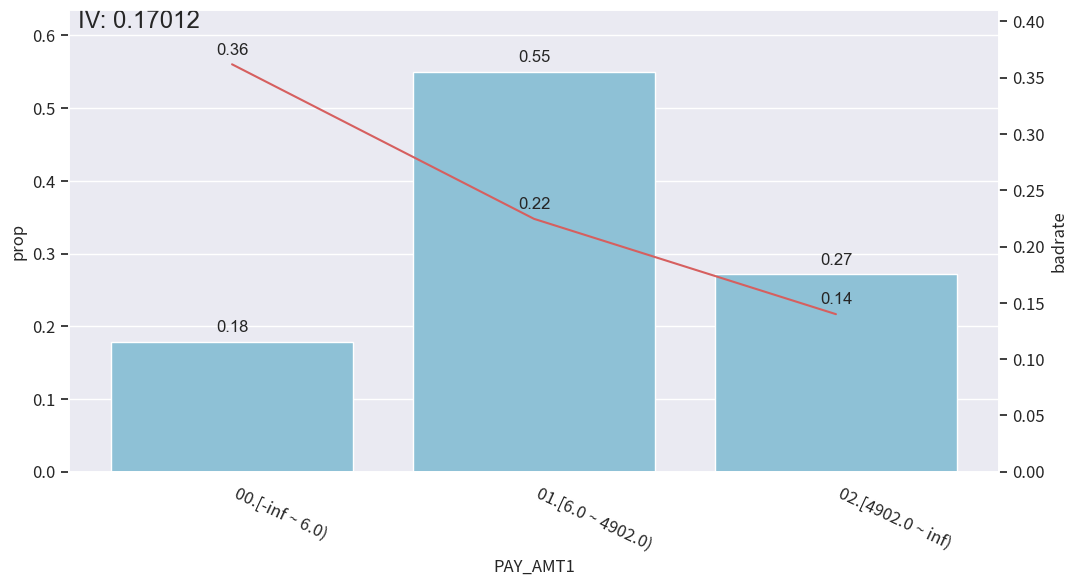

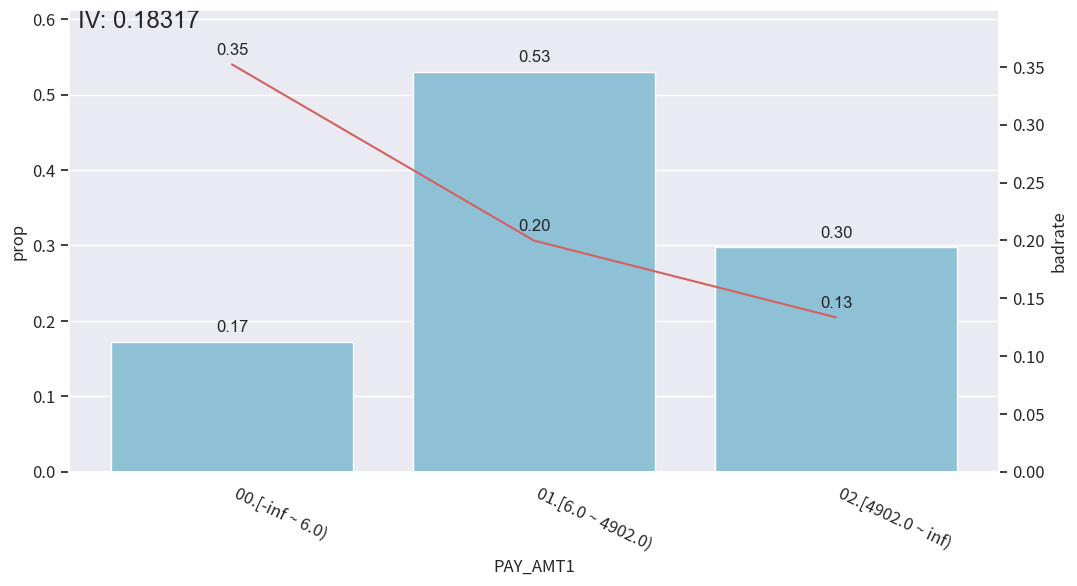

In [37]:
# Fine tune bins
from toad.plot import  bin_plot, badrate_plot

np.str = str
bin_plot(train_selected_bin,x='PAY_AMT1',target='label')
bin_plot(test_bin,x='PAY_AMT1',target='label')

<Axes: xlabel='LIMIT_BAL', ylabel='badrate'>

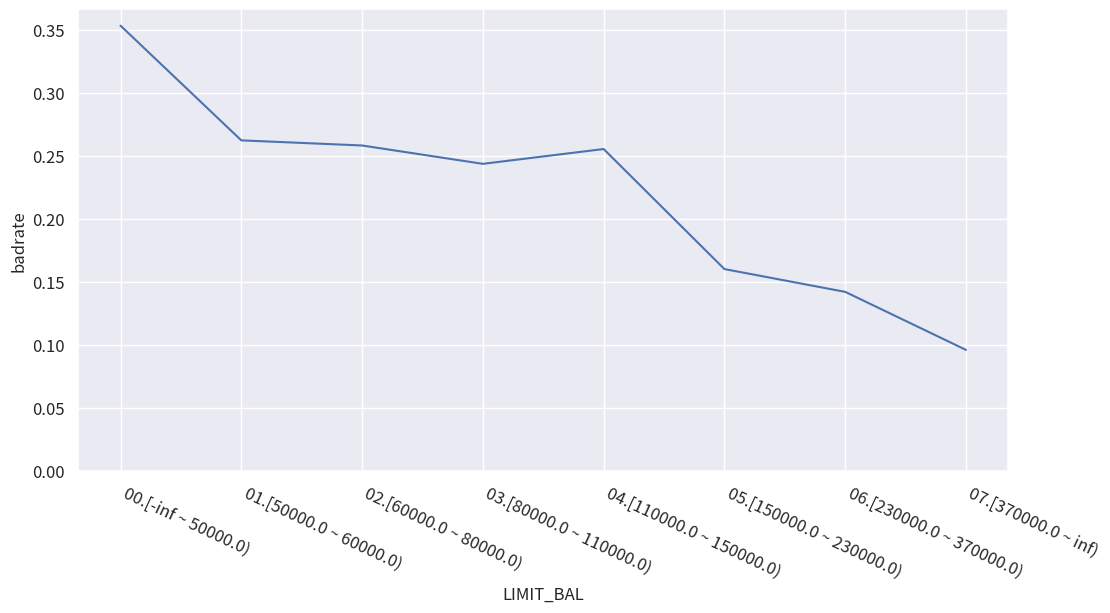

In [38]:
# A feature is preferrable if the gaps between classes get wider as time 
# goes by - it means the binned classes have larger difference. 
# No line crossing means the bin results are stable
# - target: target variable
# - x: time column, must be in string
# - by: feature column of interest
badrate_plot(test_bin, x='LIMIT_BAL', target='label', by=None)

In [39]:
# Setting rules
# rule = {'PAY_AMT1':[['0', 'nan'],['1'], ['2'], ['3']]}

# Adjust binning
# c.set_rules(rule)

# Pass new bins
# c.update(rule)

In [40]:
train_selected_bin.PAY_0.describe()

count          22499
unique             5
top       02.[0 ~ 1)
freq           11068
Name: PAY_0, dtype: object

# 4. Transform to WOE

In [41]:
## Convert to WOE mapping
t=toad.transform.WOETransformer()

#transform training set
train_woe = t.fit_transform(X=train_selected_bin,
                            y=train_selected_bin['label'], 
                            exclude=exclude_list)

#transform testing set
test_woe = t.transform(test_bin)

In [42]:
train_woe.head()

,ID,LIMIT_BAL,PAY_0,PAY_2,PAY_5,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,1,0.666522,2.019269,1.459809,-0.146325,0.662394,0.124160,0.488183,0.454327,0.370272,0.343887,1
1,2,-0.034630,-0.308169,1.459809,-0.203587,0.662394,0.124160,0.016060,0.056501,0.370272,-0.082401,1
2,3,0.108342,-0.677822,-0.408118,-0.203587,-0.009085,0.124160,0.016060,0.056501,0.084926,-0.391360,0
3,4,0.200392,-0.677822,-0.408118,-0.203587,-0.009085,-0.076846,0.016060,0.056501,0.084926,-0.119586,0
4,5,0.200392,-0.308169,-0.408118,-0.203587,-0.009085,-1.078550,-0.372758,-0.457199,0.084926,0.257636,0


In [43]:
final_data_woe = pd.concat([train_woe, test_woe])

In [44]:
#save 2: pickle woe_transform
filename = 'CreditScore_save2_woe_transform.pkl'
pickle.dump(t, open(filename, 'wb'))

In [45]:
features_use = [feat for feat in final_data_woe.columns if feat not in exclude_list]
len(features_use)

10

In [46]:
final_woe_score = t.export()
tkeys = list(t.export().keys())
woe_df = pd.DataFrame()
for n in tkeys:
    ttemp = pd.DataFrame.from_dict(final_woe_score[n], orient='index')
    ttemp = ttemp.reset_index()
    ttemp.columns= ['binning','woe']
    ttemp['variable'] = n
    ttemp = ttemp[['variable','binning','woe']]
    woe_df=pd.concat([woe_df, ttemp])
woe_df.head(30)

,variable,binning,woe
0,LIMIT_BAL,00.[-inf ~ 50000.0),0.666522
1,LIMIT_BAL,01.[50000.0 ~ 60000.0),0.200392
2,LIMIT_BAL,02.[60000.0 ~ 80000.0),0.346262
3,LIMIT_BAL,03.[80000.0 ~ 110000.0),0.108342
4,LIMIT_BAL,04.[110000.0 ~ 150000.0),-0.034630
5,LIMIT_BAL,05.[150000.0 ~ 230000.0),-0.280994
6,LIMIT_BAL,06.[230000.0 ~ 370000.0),-0.436625
7,LIMIT_BAL,07.[370000.0 ~ inf),-0.693420
0,PAY_0,00.[-inf ~ -1),-0.675097
1,PAY_0,01.[-1 ~ 0),-0.308169


## Stepwise regression feature selection

In [47]:
# - estimator: the regression model to fit, support 'ols', 'lr', 'lasso', 'ridge'
# - direction: stepwise direction, support 'forward', 'backward', 'both' (recommended)
# - criterion: selection criteria, support 'aic', 'bic', 'ks', 'auc'
# - max_iter: maximum number of iterations
# - return_drop: whether to return a list of dropped column names
# - exclude: list of columns to be excluded from alogorithm, such as ID column and time column.
# generally, direction = ‘both’ produces the best results. 
# Setting estimator = ‘ols’ and criterion = ‘aic’ makes the stepwise fast 
# and the results are sound for logistic regression
# Apply stepwise regression on the WOE-transformed data
np.object = object
train_woe_stepwise = toad.selection.stepwise(train_woe,
                                             target = train_woe['label'], 
                                             estimator='ols', 
                                             direction = 'both', 
                                             criterion = 'aic', 
                                             exclude = exclude_list)

#  Place the selected features to test / OOT sample
test_woe_stepwise = test_woe[train_woe_stepwise.columns]

print(train_woe_stepwise.shape)

(22499, 8)


In [48]:
train_woe_stepwise.head()

,ID,LIMIT_BAL,PAY_0,PAY_2,PAY_5,PAY_AMT2,PAY_AMT3,label
0,1,0.666522,2.019269,1.459809,-0.146325,0.124160,0.488183,1
1,2,-0.034630,-0.308169,1.459809,-0.203587,0.124160,0.016060,1
2,3,0.108342,-0.677822,-0.408118,-0.203587,0.124160,0.016060,0
3,4,0.200392,-0.677822,-0.408118,-0.203587,-0.076846,0.016060,0
4,5,0.200392,-0.308169,-0.408118,-0.203587,-1.078550,-0.372758,0


In [49]:
features_use = [feat for feat in train_woe_stepwise.columns if feat not in exclude_list]
len(features_use)

6

## Calculate PSI
* PSI (Population Stability Index) reflects the stability of the distribution. We often use it to screen features and evaluate model stability. The industry level is to drop features with a PSI greater than 0.2

In [50]:
#get the feature name
features_list = [feat for feat in train_woe_stepwise.columns if feat not in exclude_list]

#calculate PSI using toad
psi_df = toad.metrics.PSI(train_woe_stepwise[features_list], test_woe_stepwise[features_list]).sort_values()

#put into a dataframe
psi_df = psi_df.reset_index()
psi_df = psi_df.rename(columns = {'index' : 'feature',0:'psi'})
psi_df

,feature,psi
0,PAY_AMT2,0.010605
1,PAY_2,0.012077
2,PAY_5,0.014513
3,PAY_AMT3,0.016165
4,LIMIT_BAL,0.018541
5,PAY_0,0.022814


In [51]:
# features less than 0.25
psi025 = list(psi_df[psi_df.psi<0.25].feature)

# features geater than 0.25
psi_remove = list(psi_df[psi_df.psi>=0.25].feature)
psi_remove

[]

In [52]:
# keep exclude list
for i in exclude_list:
    if i in psi025:
        pass
    else:
       psi025.append(i) 

In [53]:
# remove features that are geater than 0.25
train_selected_woe_psi = train_woe_stepwise[psi025]
off_woe_psi = test_woe_stepwise[psi025]

In [54]:
# output our final data table
final_data_woe = pd.concat([train_selected_woe_psi, off_woe_psi])

In [55]:
print(final_data_woe.shape)

(30000, 8)


In [56]:
#save 3: final data table with transformed woe
final_data_woe.to_csv('CreditScore_save3_final_data_woe.csv')

# 5. Output IV

In [57]:
features_use = [feat for feat in train_selected_woe_psi.columns if feat not in exclude_list]
len(features_use)

6

In [58]:
###feature filtering by missing value, IV & corrrelation：
##If the missing value rate is greater than the threshold, delete the feature
##If the correlation coefficient is greater than the threshold, delete the feature
##If the IV is smaller than the threshold, delete the features
train_selected_woe_psi_selected, drop_lst_selected= toad.selection.select(frame = train_selected_woe_psi,
                                                target = train_selected_woe_psi['label'], 
                                                empty = 0.5, 
                                                iv = 0.05, corr = 0.7, 
                                                return_drop=True, 
                                                exclude=exclude_list)

print("keep:",train_selected_woe_psi_selected.shape[1],
      ", drop empty:",len(drop_lst_selected['empty']),
      ", drop iv:",len(drop_lst_selected['iv']),
      ", drop corr:",len(drop_lst_selected['corr']))

keep: 8 , drop empty: 0 , drop iv: 0 , drop corr: 0


In [59]:
features_use = [feat for feat in train_selected_woe_psi_selected.columns if feat not in exclude_list]
len(features_use)

6

In [60]:
df_iv = output_iv_importance(train_selected_woe_psi_selected[features_use+['label']],'label')
df_iv = df_iv[df_iv['iv'] < 0.5].reset_index(drop=True)

In [61]:
df_iv

,name,iv
0,PAY_5,0.332450
1,LIMIT_BAL,0.169124
2,PAY_AMT2,0.153778
3,PAY_AMT3,0.098665


<Figure size 1800x600 with 0 Axes>

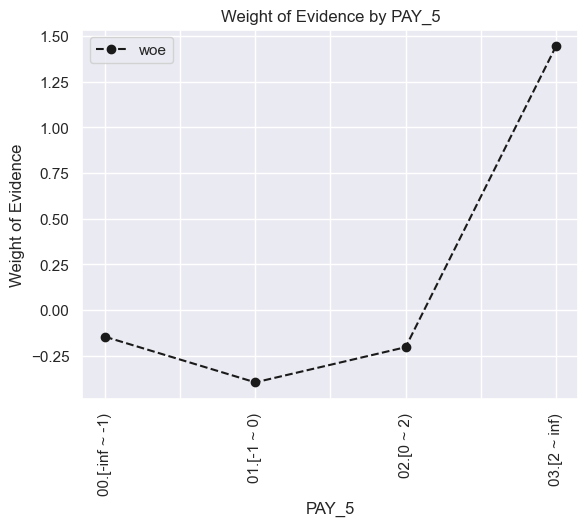

<Figure size 1800x600 with 0 Axes>

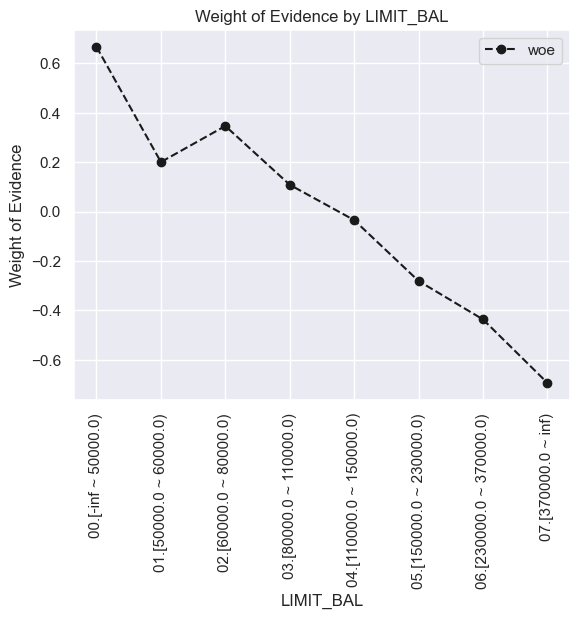

<Figure size 1800x600 with 0 Axes>

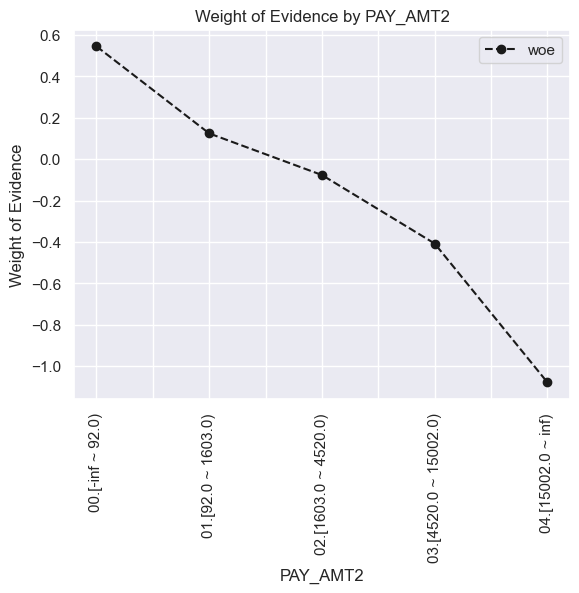

<Figure size 1800x600 with 0 Axes>

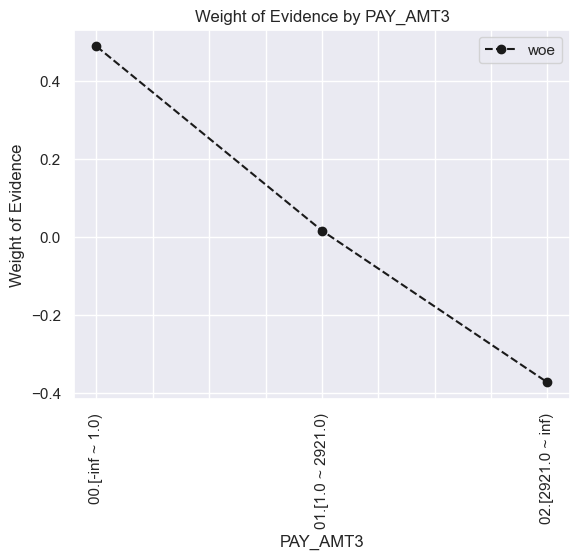

In [62]:
for var in df_iv.name.unique():
    plt.figure(figsize=(18, 6))
    woe_df[woe_df['variable'] == var].plot(x='binning', y='woe', rot=90, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(var)
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + var))

In [63]:
#save 4: information value after woe transformation
df_iv.to_csv('CreditScore_save4_IV.csv')

# 6. Model Tuning

In [64]:
def check_train_test_auc(x_train,y_train,x_test,y_test):
    # Modeling with logistic regression
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, classification_report
    
    lr = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg', class_weight='balanced')
    lr.fit(x_train, y_train)

    # Predictive training and OOT every other month
    pred_train = lr.predict_proba(x_train)[:,1]
    
    from toad.metrics import KS, AUC
    
    print('Train KS:',KS(pred_train, y_train))
    print('Train AUC:',AUC(pred_train, y_train))
    print('Train GINI:',roc_auc_score(y_train, pred_train) * 2 - 1)
    
    pred_OOT =lr.predict_proba(x_test)[:,1]
    print('')
    print('Test KS:',KS(pred_OOT, y_test))
    print('Test AUC:',AUC(pred_OOT, y_test))
    print('Test GINI:',roc_auc_score(y_test, pred_OOT) * 2 - 1)

    # PSI also be used to gauge the stability of predicted proabilities
    print('')
    print('PSI (train vs test probabilities):', toad.metrics.PSI(pred_train, pred_OOT))

    # Calculate Youden's J-Statistic to identify the best threshhold
    fpr, tpr, thresholds = roc_curve(y_test, pred_OOT)
    J = tpr - fpr
    
    # locate the index of the largest J
    ix = np.argmax(J)
    best_thresh = 1 - thresholds[ix]
    print('')
    print('Best Threshold: %f' % (best_thresh))

    # Group the predicted scores in bins with same number of samples in each (i.e. "quantile" binning)
    # - method：method of binning. Recommend to use 'quantile' or 'step'
    # (1) the larger the difference of bad_rate between each group, the better the results; 
    # (2) can be used to check the monotonicity of groups of scores; 
    # (3) can be used to find the optimal cutoff point; 
    # (4) can be used to compare predictability of models
    print('')
    pd.options.display.max_columns = None
    display(toad.metrics.KS_bucket(1-pred_train, y_train, bucket=10, method = 'quantile'))

    fig, ax = plt.subplots(figsize=(12, 8))

    RocCurveDisplay.from_estimator(lr, x_test, y_test, color='blue', ax=ax)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

## Logistic Regression

In [65]:
features_use = [feat for feat in df_iv.name if feat not in exclude_list]
len(features_use)

4

Train KS: 0.29059669228843615
Train AUC: 0.6965243036102023
Train GINI: 0.3930486072204047

Test KS: 0.3151311023343495
Test AUC: 0.7087552429431061
Test GINI: 0.4175104858862122

PSI (train vs test probabilities): 0.13183810114470473

Best Threshold: 0.540291



,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,total_prop,cum_bad_rate,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.094749,0.302794,1236,1009,2245,0.550557,0.449443,1.224975,0.242925,0.057952,0.099782,0.550557,0.226143,0.242925,1.000000,0.057952,1.000000,0.099782,1.000000,0.184973,2.434547,2.434547
1,0.306850,0.430029,735,1442,2177,0.337621,0.662379,0.509709,0.144458,0.082821,0.096760,0.445726,0.190185,0.387382,0.757075,0.140773,0.942048,0.196542,0.900218,0.246609,1.492949,1.970988
2,0.430120,0.472200,654,1647,2301,0.284224,0.715776,0.397086,0.128538,0.094595,0.102271,0.390451,0.172429,0.515920,0.612618,0.235368,0.859227,0.298813,0.803458,0.280551,1.256832,1.726563
3,0.472580,0.511188,528,1723,2251,0.234562,0.765438,0.306442,0.103774,0.098960,0.100049,0.351348,0.156123,0.619693,0.484080,0.334329,0.764632,0.398862,0.701187,0.285365,1.037229,1.553653
4,0.511403,0.545862,451,1810,2261,0.199469,0.800531,0.249171,0.088640,0.103957,0.100493,0.320783,0.143068,0.708333,0.380307,0.438286,0.665671,0.499356,0.601138,0.270047,0.882048,1.418495
5,0.545967,0.589404,399,1792,2191,0.182109,0.817891,0.222656,0.078420,0.102923,0.097382,0.298153,0.131747,0.786753,0.291667,0.541210,0.561714,0.596738,0.500644,0.245544,0.805279,1.318424
6,0.589518,0.622695,335,1842,2177,0.153881,0.846119,0.181868,0.065841,0.105795,0.096760,0.278023,0.119586,0.852594,0.213247,0.647005,0.458790,0.693497,0.403262,0.205590,0.680460,1.229412
7,0.626078,0.673397,287,2109,2396,0.119783,0.880217,0.136083,0.056407,0.121130,0.106494,0.256959,0.108759,0.909002,0.147406,0.768135,0.352995,0.799991,0.306503,0.140866,0.529677,1.136265
8,0.677172,0.705968,181,1432,1613,0.112213,0.887787,0.126397,0.035574,0.082247,0.071692,0.245054,0.102889,0.944575,0.090998,0.850382,0.231865,0.871683,0.200009,0.094194,0.496204,1.083622
9,0.706827,0.834908,282,2605,2887,0.097679,0.902321,0.108253,0.055425,0.149618,0.128317,0.226143,0.097679,1.000000,0.055425,1.000000,0.149618,1.000000,0.128317,0.000000,0.431935,1.000000


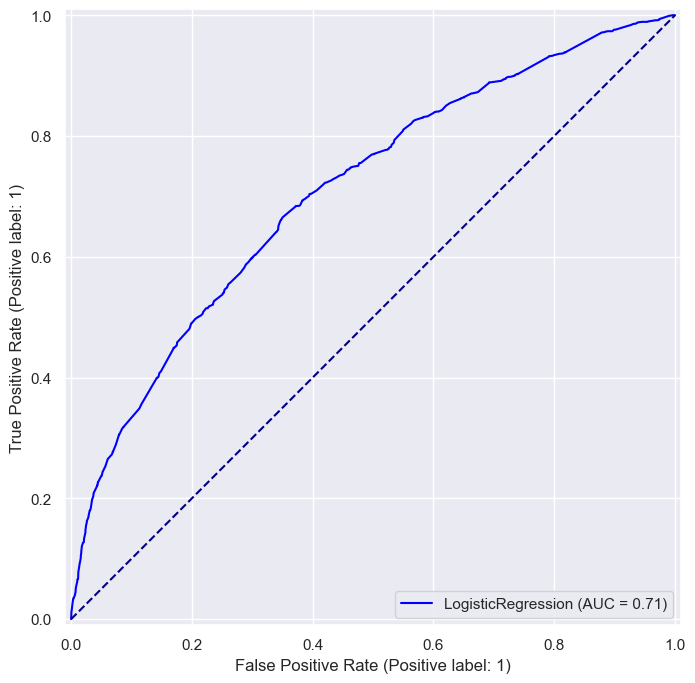

In [66]:
#train & test
check_train_test_auc(x_train = train_woe[features_use], y_train=train_woe['label'],
                     x_test=test_woe[features_use], y_test = test_woe['label'])

In [67]:
def get_evaluation_scores(label, predictions):
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.metrics import balanced_accuracy_score
    
    tp, fn, fp, tn = confusion_matrix(label, predictions, labels=[1,0]).reshape(-1)
    print('True Positive：',tp)
    print('True Negative：',tn)
    print('False Positive：',fp)
    print('False Negative：',fn)
    
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    print('Accuracy: ',accuracy)
    
    recall = tp / (tp + fn)
    print('Recall: ',recall)
    
    precision = tp / (tp + fp)
    print('Precision: ',precision)
    
    #f1 score = 2*(P*R)/(P+R)
    f1 = 2 * precision * recall / (precision + recall)
    print('F1 score: ',f1)

    print('Balanced_accuracy_score: ',balanced_accuracy_score(label, predictions))
    
    print(classification_report(label, predictions))
    
    return precision, recall

def evaluate_result(df_train,df_test,features_name):
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    start = time.time()
    x_train = df_train[features_name]
    y_train = df_train['label']

    x_test  = df_test[features_name]
    y_test  = df_test['label']

    # GBDT encoding - pre-processing for gbdt + lr technique.
    train_selected_bin_cat = combiner.transform(train_selected, labels=False)
    test_bin_cat = combiner.transform(test[train_selected_bin.columns], labels=False)
    
    gbdt_transer = toad.transform.GBDTTransformer()
    gbdt_transer.fit(train_selected_bin_cat[features_use+['label']], 'label', n_estimators = 10, max_depth = 2)
    x_train = gbdt_transer.transform(train_selected_bin_cat[features_use])
    x_test = gbdt_transer.transform(test_bin_cat[features_use])

    model = GradientBoostingClassifier(n_estimators=250,random_state=0)
    # model = LogisticRegression(random_state=42,C= 0.1, penalty='l2', solver='newton-cg', class_weight='balanced')
    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    
    get_evaluation_scores(label = y_test, predictions=predictions)

    try:
        feat_importances = pd.Series(model.feature_importances_, index=features_name)
        feat_importances=pd.DataFrame(feat_importances).reset_index()
        feat_importances.columns=['feature_name','feature_importance']
        feat_importances=feat_importances.sort_values(['feature_importance'],ascending=False)
        
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15,15))
    
        sns_plot1=sns.barplot(x=feat_importances.feature_importance,y=feat_importances.feature_name,estimator=sum)
        plt.title("Features Importance",size=18)
        plt.ylabel('', size = 15)
        plt.tick_params(labelsize=18)
        
        return feat_importances,model,x_train,y_train,x_test,y_test
    except:
        return _,model,x_train,y_train,x_test,y_test

## Train a GBDT and check the feauture importance table

In [68]:
fet_importance_GBDT_reason,model,x_train,y_train,x_test,y_test = evaluate_result(df_train=train_woe,
                                                                                    df_test=test_woe,
                                                                                    features_name=features_use)

C:\Users\FM\anaconda3\envs\csc\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\FM\anaconda3\envs\csc\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\FM\anaconda3\envs\csc\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


True Positive： 313
True Negative： 5725
False Positive： 228
False Negative： 1235
Accuracy:  0.8049593387548327
Recall:  0.20219638242894056
Precision:  0.5785582255083179
F1 score:  0.2996649114408808
Balanced_accuracy_score:  0.5819481828153438
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      5953
           1       0.58      0.20      0.30      1548

    accuracy                           0.80      7501
   macro avg       0.70      0.58      0.59      7501
weighted avg       0.77      0.80      0.77      7501



In [69]:
fet_importance_GBDT_reason

4

In [70]:
def plot_roc_pre_recall_curve(labels, probs):
    from sklearn.metrics import precision_recall_curve
    
    # Get ROC curve FPR and TPR from true labels vs score values
    fpr, tpr, _ = roc_curve(labels, probs)

    # Calculate ROC Area Under the Curve (AUC) from FPR and TPR data points
    roc_auc = auc(fpr, tpr)

    # Calculate precision and recall from true labels vs score values
    precision, recall, _ = precision_recall_curve(labels, probs)

    plt.figure(figsize=(8, 3))
    plt.subplot(1,2,1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.subplot(1,2,2)
    
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(labels[labels == 1]) / len(labels)
    
    # plot the no skill precision-recall curve
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    
    plt.step(recall, precision, color='orange', where='post', label='Logistic')
    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.grid(True)

    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure 
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.5   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    plt.show()

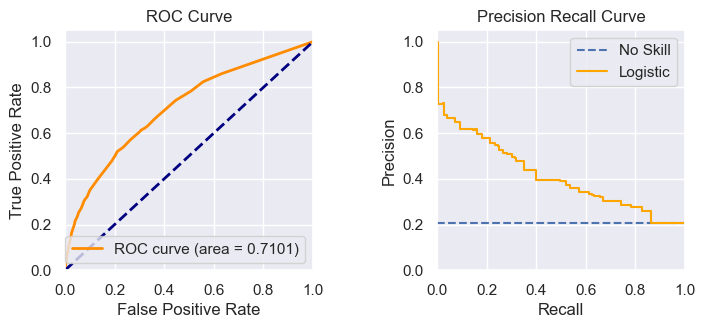

In [71]:
probs = model.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

# 7. Model Production

In [72]:
# prepare train & test data
# x_train = train_woe[features_use]
y_train=train_woe['label']
# x_test =test_woe[features_use] 
y_test = test_woe['label']

x_train = pd.get_dummies(train_selected_bin[features_use], dtype=float)
x_test = pd.get_dummies(test_bin[features_use], dtype=float)

# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
# x_test = pd.concat([x_test, pd.DataFrame(dict.fromkeys(set(x_train.columns) - set(x_test.columns), [0] * len(x_test)), index = x_test.index)], axis = 1)
x_test = x_test.reindex(labels=x_train.columns, axis=1, fill_value=0)

print(x_train.shape)
print(x_test.shape)

(22499, 20)
(7501, 20)


In [73]:
#Train LR
lr = LogisticRegression(random_state=42, C= 0.1, penalty='l2', solver='newton-cg', class_weight='balanced')
lr.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=42,
                   solver='newton-cg')

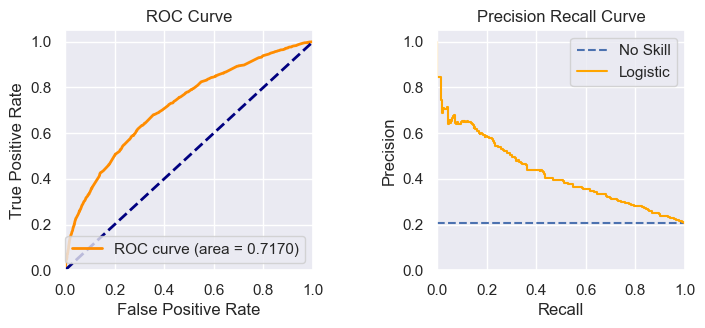

In [74]:
#check AUC
probs = lr.predict_proba(x_test)[:,1]
sns.set(font_scale = 1)
plot_roc_pre_recall_curve(y_test, probs)

# 8. Scorecard Generation

In [75]:
# scorecard tuning
# Convert logit into a standard scorecard. Support direct input of 
# parameters of a LogisticRegression class
# e.g. pdo=60|80, rate=2, base_odds=20|35,base_score=750|1000
# it means when odds is 1/60, the base socre is 750
card = toad.ScoreCard(
    combiner = combiner,
    transer = t,
    class_weight = 'balanced',
    C=0.1,
    penalty='l2', 
    solver='newton-cg',
    base_score = 1000,
    base_odds = 35 ,
    pdo = 80,
    rate = 2
)

card.fit(train_woe[features_use], train_woe['label'])

ScoreCard(base_score=1000,
          combiner=<toad.transform.Combiner object at 0x00000248C8FFB5E0>,
          pdo=80,
          transer=<toad.transform.WOETransformer object at 0x00000248CB527760>)

In [76]:
# save 5: save the model to disk
filename = 'CreditScore_save5_ScoreCard.pkl'
pickle.dump(card, open(filename, 'wb'))

In [77]:
#inference on test data
test['CreditScore'] = card.predict(test)
test['PropensityScore'] = 1 - lr.predict_proba(x_test)[:,1]
test['CreditScore'].describe()

count    7501.000000
mean      614.266976
std        79.542185
min       329.166480
25%       571.840861
50%       622.850352
75%       668.143893
max       776.725078
Name: CreditScore, dtype: float64

In [78]:
#inference on whole data
data['CreditScore'] = card.predict(data)
data['CreditScore'].describe()

count    30000.000000
mean       606.384492
std         82.584403
min        329.166480
25%        564.762029
50%        613.498125
75%        663.803055
max        776.725078
Name: CreditScore, dtype: float64

In [79]:
#output the scorecard
final_card_score=card.export()
len(final_card_score)

4

In [80]:
#transform the scorecard into dataframe and save to csv
keys = list(card.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_card_score[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df=pd.concat([score_card_df, temp])
score_card_df.head(30)

,variable,binning,score
0,PAY_5,[-inf ~ -1),162.51
1,PAY_5,[-1 ~ 0),188.20
2,PAY_5,[0 ~ 2),168.40
3,PAY_5,[2 ~ inf),-0.93
0,LIMIT_BAL,[-inf ~ 50000.0),103.87
1,LIMIT_BAL,[50000.0 ~ 60000.0),134.36
2,LIMIT_BAL,[60000.0 ~ 80000.0),124.81
3,LIMIT_BAL,[80000.0 ~ 110000.0),140.38
4,LIMIT_BAL,[110000.0 ~ 150000.0),149.73
5,LIMIT_BAL,[150000.0 ~ 230000.0),165.84


In [81]:
#save 6: save the scorcard
score_card_df.to_csv('CreditScore_save6_score_card_df.csv',index=False)

# 9. Distribution Analysis

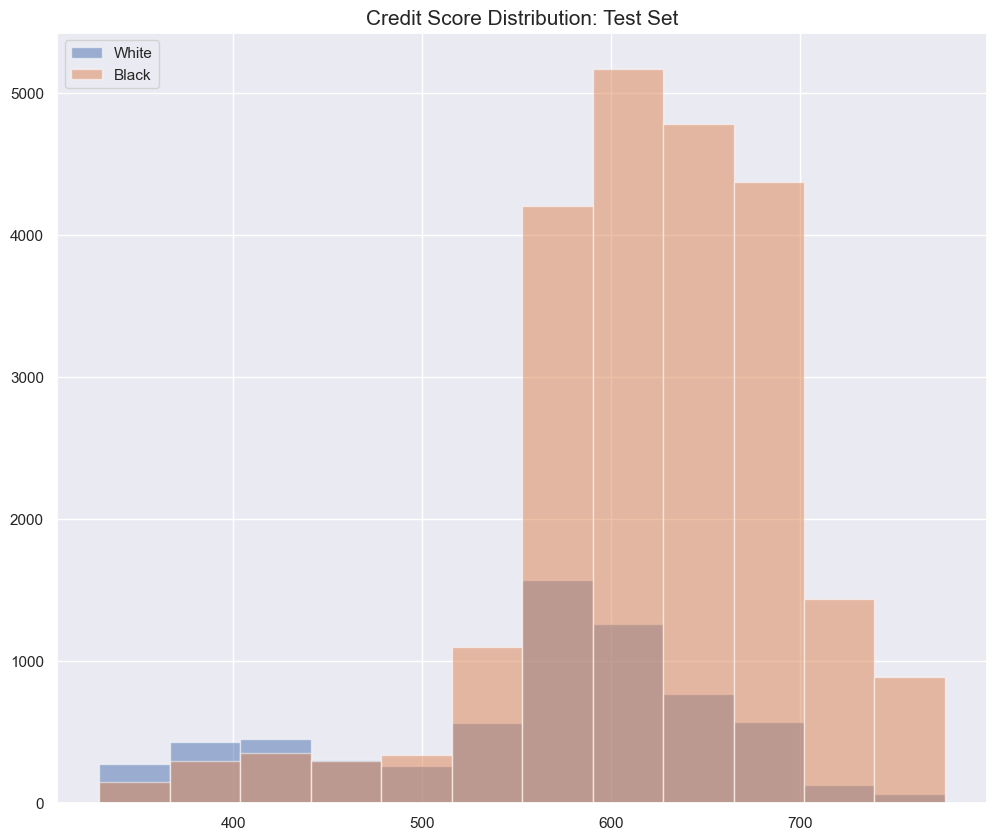

In [82]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((data['CreditScore'].max() - data['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(data[data.label==1].CreditScore, alpha=0.5, label='White',bins = n)
plt.hist(data[data.label==0].CreditScore, alpha=0.5, label='Black',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Test Set',size=15)
plt.show()

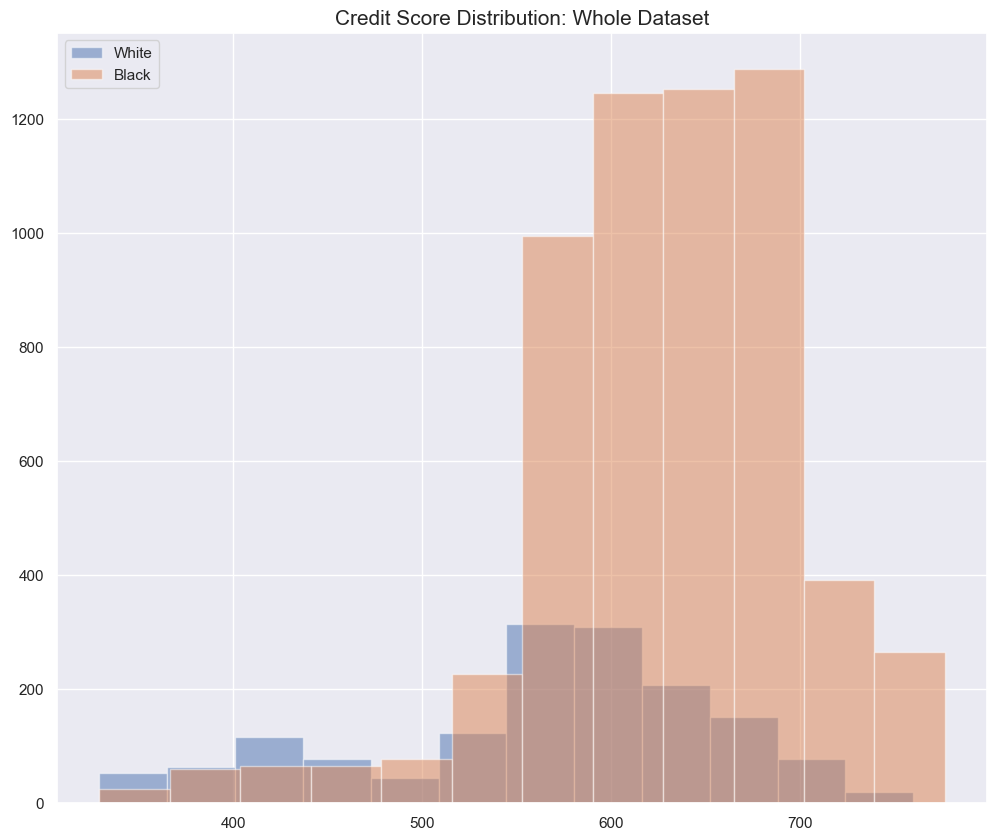

In [83]:
plt.figure(figsize=(12,10))
import random
import numpy
from matplotlib import pyplot as plt

w = 40
n = math.ceil((test['CreditScore'].max() - test['CreditScore'].min())/w)
#bins = numpy.linspace(-10, 10, 100)

plt.hist(test[test.label==1].CreditScore, alpha=0.5, label='White',bins = n)
plt.hist(test[test.label==0].CreditScore, alpha=0.5, label='Black',bins = n)
plt.legend(loc='upper left')
plt.title('Credit Score Distribution: Whole Dataset',size=15)
plt.show()

# 10. Threshold Tuning

In [84]:
def get_credit_level(
    test,
    target_score ='order_score',
    out_col = 'order_level',
    left_bound = -100,
    level_0 = 100,
    level_1 = 200,    
    level_2 = 250,    
    level_3 = 300,    
    level_4 = 350,    
    level_5 = 400,    
    level_6 = 450,
    level_7 = 500,
    level_8 = 800):
    level = []
    for i in range(len(test)):
        if (test[target_score][i]>left_bound) & (test[target_score][i]<=level_0):
            level.append(0)
        elif  (test[target_score][i]>level_0) & (test[target_score][i]<=level_1):
            level.append(1)
        elif  (test[target_score][i]>level_1) & (test[target_score][i]<=level_2):
            level.append(2)
        elif  (test[target_score][i]>level_2) & (test[target_score][i]<=level_3):
            level.append(3)
        elif  (test[target_score][i]>level_3) & (test[target_score][i]<=level_4):
            level.append(4)
        elif  (test[target_score][i]>level_4) & (test[target_score][i]<=level_5):
            level.append(5)
        elif  (test[target_score][i]>level_5) & (test[target_score][i]<=level_6):
            level.append(6)
        elif  (test[target_score][i]>level_6) & (test[target_score][i]<=level_7):
            level.append(7)
        elif  (test[target_score][i]>level_7 )& (test[target_score][i]<=level_8):
            level.append(8)
        
    test[out_col] = level
    return test

def plot_bts_level_loss(test, target_col):
    bts_level_df = test[target_col].value_counts()
    bts_level_df=pd.DataFrame(bts_level_df)
    
    df_label_level= test[test.label==1].groupby(target_col)['label'].count()/ test.groupby(target_col)['label'].count()
    df_label_level = pd.DataFrame(df_label_level)
    
    bts_level_df.sort_index().plot.bar(title='')
    df_label_level.plot()

In [85]:
test.CreditScore.describe()

count    7501.000000
mean      614.266976
std        79.542185
min       329.166480
25%       571.840861
50%       622.850352
75%       668.143893
max       776.725078
Name: CreditScore, dtype: float64

### Threshold Tuning & Trade-off between loss & Coverage

In [86]:
test = get_credit_level(test,
                       target_score ='CreditScore',
                       out_col = 'CreditScore_level',
                      left_bound = -1000,
    level_0 = 250,
    level_1 = 300,    
    level_2 = 400,    
    level_3 = 500,    
    level_4 = 580,    
    level_5 = 630,    
    level_6 = 690,
    level_7 = 730,
    level_8 = 1000
                )

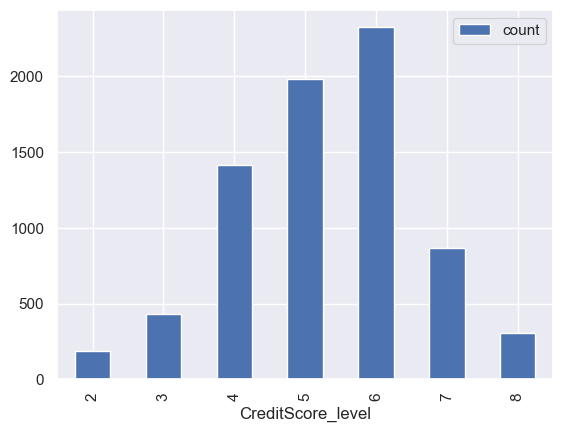

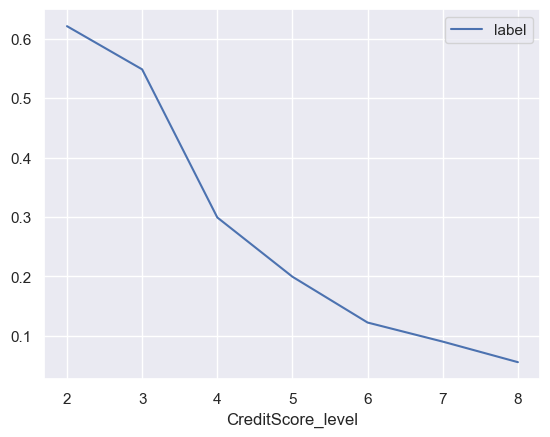

In [87]:
plot_bts_level_loss(test,target_col='CreditScore_level')

In [88]:
sum(test[test.label==1].CreditScore_level==7)

78

In [89]:
def get_loss_coverage(test,target_level):
    
    #level 8 Loss
    L8_loss=test[test[target_level]>=8 ].label.value_counts()/len(test[test[target_level]>=8 ])
    #level 8 Coverage
    L8_coverage=test[test[target_level]>=8].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 8: Loss is ",L8_loss[1], "; Coverage is ",L8_coverage)
    
    #level 7-level 8 Loss
    L7_loss=test[test[target_level]>=7 ].label.value_counts()/len(test[test[target_level]>=7 ])
    #level 7-level 8 Coverage
    L7_coverage=test[test[target_level]>=7].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 7-Level 8: Loss is ",L7_loss[1], "; Coverage is ",L7_coverage)
    
    #level 6-level 8 Loss
    L6_loss=test[test[target_level]>=6 ].label.value_counts()/len(test[test[target_level]>=6 ])
    #level 6-level 8 Coverage
    L6_coverage=test[test[target_level]>=6].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 6-Level 8: Loss is ",L6_loss[1], "; Coverage is ",L6_coverage)
    
     #level 5-Leve 8 Loss (percentage of default people)
    L5_loss = test[test[target_level]>=5 ].label.value_counts()/len(test[test[target_level]>=5 ])
    #level 5- level 8 Coverage (percentage of good people)
    L5_coverage=test[test[target_level]>=5 ].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 5-Level 8: Loss is ",L5_loss[1], "; Coverage is ",L5_coverage)
    
    #level 4-level 8 Loss
    L4_loss=test[test[target_level]>=4 ].label.value_counts()/len(test[test[target_level]>=4 ])
    #level 4-level 8 Coverage
    L4_coverage=test[test[target_level]>=4].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 4-Level 8: Loss is ",L4_loss[1], "; Coverage is ",L4_coverage)
    
    
    #level 3-level 8 Loss
    L3_loss=test[test[target_level]>=3].label.value_counts()/len(test[test[target_level]>=3 ])
    #level 3-level 8 Coverage
    L3_coverage=test[test[target_level]>=3].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 3-Level 8: Loss is ",L3_loss[1], "; Coverage is ",L3_coverage)
    
    #level 2-level 8 Loss
    L2_loss=test[test[target_level]>=2].label.value_counts()/len(test[test[target_level]>=2 ])
    #level 2-level 8 Coverage
    L2_coverage=test[test[target_level]>=2].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 2-Level 8: Loss is ",L2_loss[1], "; Coverage is ",L2_coverage)
    
    #level 1-level 8 Loss
    L1_loss=test[test[target_level]>=1].label.value_counts()/len(test[test[target_level]>=1 ])
    #level 1-level 8 Coverage
    L1_coverage=test[test[target_level]>=1].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 1-Level 8: Loss is ",L1_loss[1], "; Coverage is ",L1_coverage)
    
    #level 0-level 8 Loss
    L0_loss=test[test[target_level]>=0].label.value_counts()/len(test[test[target_level]>=0 ])
    #level 0-level 8 Coverage
    L0_coverage=test[test[target_level]>=0].label.value_counts()[0]/test[test.label==0].shape[0]
    print("Level 0-Level 8: Loss is ",L0_loss[1], "; Coverage is ",L0_coverage)

In [90]:
get_loss_coverage(test,target_level='CreditScore_level')

Level 8: Loss is  0.05555555555555555 ; Coverage is  0.04854695111708383
Level 7-Level 8: Loss is  0.08112724167378309 ; Coverage is  0.18074920208298337
Level 6-Level 8: Loss is  0.10850271972516462 ; Coverage is  0.5230975978498236
Level 5-Level 8: Loss is  0.14142152384432669 ; Coverage is  0.7893499076096085
Level 4-Level 8: Loss is  0.17383096137089749 ; Coverage is  0.9556526121283386
Level 3-Level 8: Loss is  0.1958720612356479 ; Coverage is  0.988241222912817
Level 2-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0
Level 1-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0
Level 0-Level 8: Loss is  0.20637248366884414 ; Coverage is  1.0


In [91]:
#save 7: save the scorcard
data.to_csv('OrderScore_save7_whole_data.csv',index=False)

In [92]:
test.loc[0,:]

ID                    22500.000000
LIMIT_BAL            420000.000000
SEX                       2.000000
EDUCATION                 2.000000
MARRIAGE                  1.000000
AGE                      37.000000
PAY_0                     0.000000
PAY_2                     0.000000
PAY_3                     0.000000
PAY_4                    -1.000000
PAY_5                     0.000000
PAY_6                     0.000000
BILL_AMT1             36032.000000
BILL_AMT2             41932.000000
BILL_AMT3              9778.000000
BILL_AMT4            158901.000000
BILL_AMT5            161876.000000
BILL_AMT6            165378.000000
PAY_AMT1               7022.000000
PAY_AMT2               1846.000000
PAY_AMT3             163862.000000
PAY_AMT4               6000.000000
PAY_AMT5               6000.000000
PAY_AMT6               6000.000000
label                     0.000000
CreditScore             683.880280
PropensityScore           0.682196
CreditScore_level         6.000000
Name: 0, dtype: floa

In [93]:
card.predict(test)[0]

683.880280376045

In [94]:
lr.predict_proba(x_test)[0, 1]

0.3178039024565293

### ML Scorecard

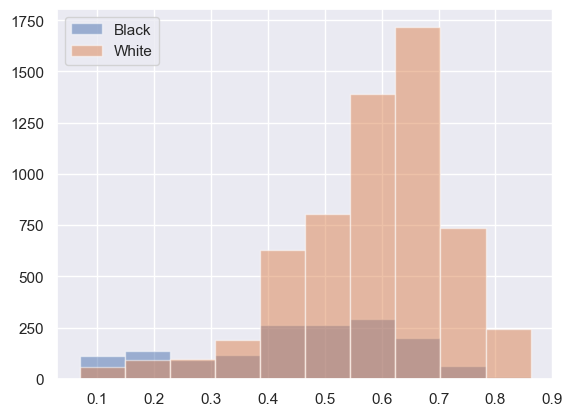

In [95]:
test_probs = x_test.copy()
credit_score = 1 - lr.predict_proba(test_probs)[:,1]

plt.hist(credit_score[y_test==1], alpha=0.5, label='Black')
plt.hist(credit_score[y_test==0], alpha=0.5, label='White')
plt.legend(loc='upper left')

<Axes: >

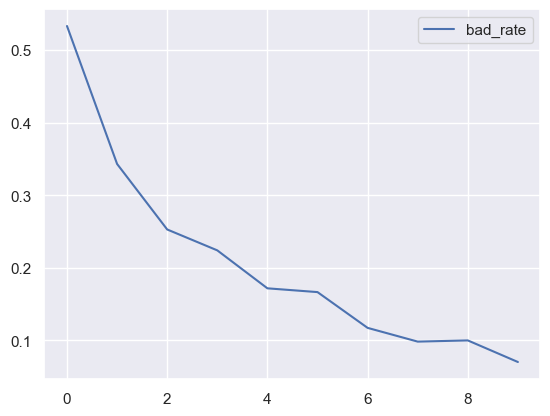

In [96]:
toad.metrics.KS_bucket(credit_score, y_test, bucket=10, method = 'quantile').plot(y='bad_rate')

In [97]:
ml_score_card_df = pd.DataFrame({'variable_binning': x_train.columns, 'coefficient': lr.coef_[0]})
ml_score_card_df = pd.concat([pd.DataFrame({'variable_binning': 'Intercept', 'coefficient': lr.intercept_}), ml_score_card_df])
ml_score_card_df['original_variable_name'] = ml_score_card_df['variable_binning'].str.split(r"_[0-9]{2}.", regex=True).str[0]

ml_score_card_df.head(30)

,variable_binning,coefficient,original_variable_name
0,Intercept,0.015265,Intercept
0,PAY_5_00.[-inf ~ -1),-0.692018,PAY_5
1,PAY_5_01.[-1 ~ 0),-0.392609,PAY_5
2,PAY_5_02.[0 ~ 2),-0.132031,PAY_5
3,PAY_5_03.[2 ~ inf),1.227904,PAY_5
4,LIMIT_BAL_00.[-inf ~ 50000.0),0.356321,LIMIT_BAL
5,LIMIT_BAL_01.[50000.0 ~ 60000.0),0.121463,LIMIT_BAL
6,LIMIT_BAL_02.[60000.0 ~ 80000.0),0.214540,LIMIT_BAL
7,LIMIT_BAL_03.[80000.0 ~ 110000.0),0.072249,LIMIT_BAL
8,LIMIT_BAL_04.[110000.0 ~ 150000.0),-0.010322,LIMIT_BAL


In [98]:
min_score = 300
max_score = 800

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = ml_score_card_df.groupby('original_variable_name')['coefficient'].min().sum()

# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = ml_score_card_df.groupby('original_variable_name')['coefficient'].max().sum()

# create a new columns that has the imputed calculated Score based on the multiplication of the coefficient by the ratio of the differences between
# maximum & minimum score and maximum & minimum sum of cefficients.
ml_score_card_df['score_calculation'] = ml_score_card_df['coefficient'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)

# update the calculated score of the Intercept (i.e. the default score for each loan)
ml_score_card_df.loc[0, 'score_calculation'] = ((ml_score_card_df.loc[0,'coefficient'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

# round the values of the 'Score - Calculation' column and store them in a new column
ml_score_card_df['score_preliminary'] = ml_score_card_df['score_calculation'].round()

min_sum_score_prel = ml_score_card_df.groupby('original_variable_name')['score_preliminary'].min().sum()
max_sum_score_prel = ml_score_card_df.groupby('original_variable_name')['score_preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

334.0
1090.0


In [99]:
# so both our min and max scores are out by +1. we need to manually adjust this
# Which one? We'll evaluate based on the rounding differences of the minimum category within each Original Feature Name.
ml_score_card_df['difference'] = ml_score_card_df['score_preliminary'] - ml_score_card_df['score_calculation']
ml_score_card_df['score_final'] = ml_score_card_df['score_preliminary']
ml_score_card_df.loc[0, 'score_final'] = ml_score_card_df.loc[0, 'score_final'] - 150

print(ml_score_card_df.groupby('original_variable_name')['score_final'].min().sum())
print(ml_score_card_df.groupby('original_variable_name')['score_final'].max().sum())

184.0
790.0


In [100]:
# insert an Intercept column in its beginning to align with the # of rows in scorecard
try:
    test_probs.insert(0, 'Intercept', 1)
except:
    None

# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = ml_score_card_df['score_final'].values.reshape(ml_score_card_df.shape[0], 1)
test['CreditScoreML'] = ml_score_card_df.groupby('original_variable_name')['score_final'].max().sum() + ml_score_card_df.groupby('original_variable_name')['score_final'].min().sum() - test_probs.dot(scorecard_scores)
test.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label,CreditScore,PropensityScore,CreditScore_level,CreditScoreML
0,22500,420000.0,2,2,1,37,0,0,0,-1,0,0,36032.0,41932.0,9778.0,158901.0,161876.0,165378.0,7022.0,1846.0,163862.0,6000.0,6000.0,6000.0,0,683.880280,0.682196,6,704.0
1,22501,180000.0,2,2,1,33,-1,-1,-1,-1,-1,-1,3490.0,0.0,1112.0,10383.0,1980.0,2672.0,0.0,1112.0,10383.0,1980.0,2672.0,2197.0,0,662.047457,0.648735,6,686.0
2,22502,230000.0,2,1,2,33,0,0,0,0,0,0,38646.0,40000.0,41354.0,42368.0,43161.0,45056.0,2000.0,2000.0,2000.0,1800.0,2600.0,2000.0,0,644.000857,0.644269,6,685.0
3,22503,50000.0,2,2,2,44,0,0,2,3,2,0,16094.0,18961.0,20857.0,20229.0,19623.0,19878.0,3155.0,2500.0,0.0,0.0,707.0,713.0,1,404.981553,0.153732,3,426.0
4,22504,260000.0,2,2,2,32,0,0,0,0,0,0,251330.0,256988.0,234260.0,227884.0,202178.0,198467.0,10000.0,9014.0,11002.0,7503.0,7502.0,7500.0,1,691.225616,0.677443,7,701.0


In [101]:
test.CreditScoreML.describe()

count    7501.000000
mean      580.273297
std       151.609504
min       184.000000
25%       508.000000
50%       643.000000
75%       690.000000
max       790.000000
Name: CreditScoreML, dtype: float64

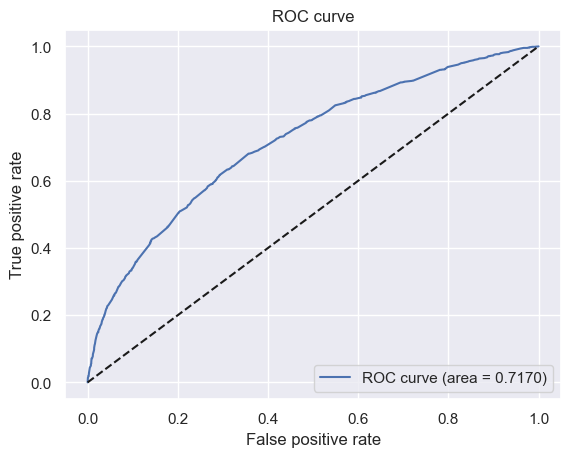

In [102]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test, 1-credit_score)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))

# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.legend(loc="lower right")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [103]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr

# locate the index of the largest J
ix = np.argmax(J)
best_thresh = 1 - thresholds[ix]

print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.531121


In [104]:
# update the threshold value
tr = 1 - best_thresh

# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_class_predicted = np.where(1 - credit_score > tr, 1, 0)

# create the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_class_predicted, normalize = 'all')

array([[0.56085855, 0.23276896],
       [0.07905613, 0.12731636]])

In [105]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])

# calcue Score corresponding to each threshold
df_cutoffs['Score'] = max_score + min_score - ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
# df_cutoffs['thresholds'] = 1 - df_cutoffs['thresholds']
df_cutoffs

,thresholds,Score
0,inf,NaN
1,0.931094,300.0
2,0.921423,316.0
3,0.914414,326.0
4,0.910483,332.0
...,...,...
392,0.159465,781.0
393,0.154396,785.0
394,0.151667,788.0
395,0.145196,793.0


In [106]:
df_cutoffs['Score'].describe()

count    396.000000
mean     592.805556
std      103.775025
min      300.000000
25%      528.750000
50%      612.000000
75%      666.250000
max      800.000000
Name: Score, dtype: float64

In [107]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(credit_score >= 1-p, 1, 0).sum()

In [108]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for all thresholds.
df_cutoffs['N_Approved'] = df_cutoffs['thresholds'].apply(n_approved)

# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N_Rejected'] = credit_score.shape[0] - df_cutoffs['N_Approved']

# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval_Rate'] = df_cutoffs['N_Approved'] / credit_score.shape[0]

# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection_Rate'] = 1 - df_cutoffs['Approval_Rate']

df_cutoffs

,thresholds,Score,N_Approved,N_Rejected,Approval_Rate,Rejection_Rate
0,inf,NaN,7501,0,1.000000,0.000000
1,0.931094,300.0,7501,0,1.000000,0.000000
2,0.921423,316.0,7475,26,0.996534,0.003466
3,0.914414,326.0,7472,29,0.996134,0.003866
4,0.910483,332.0,7462,39,0.994801,0.005199
...,...,...,...,...,...,...
392,0.159465,781.0,52,7449,0.006932,0.993068
393,0.154396,785.0,48,7453,0.006399,0.993601
394,0.151667,788.0,33,7468,0.004399,0.995601
395,0.145196,793.0,32,7469,0.004266,0.995734


In [109]:
# let's have a look at the approval and rejection rates at our ideal threshold
# We will monitor the model's performance in production.
df_cutoffs[df_cutoffs['thresholds'].between(df_cutoffs.loc[df_cutoffs.thresholds<tr, 'thresholds'].head(1).values[0], 
                                            df_cutoffs.loc[df_cutoffs.thresholds>tr, 'thresholds'].tail(1).values[0])]

,thresholds,Score,N_Approved,N_Rejected,Approval_Rate,Rejection_Rate
193,0.469732,607.0,4802,2699,0.640181,0.359819
194,0.468879,608.0,4800,2701,0.639915,0.360085
195,0.468183,608.0,4799,2702,0.639781,0.360219


In [110]:
test.loc[0,:]

ID                    22500.000000
LIMIT_BAL            420000.000000
SEX                       2.000000
EDUCATION                 2.000000
MARRIAGE                  1.000000
AGE                      37.000000
PAY_0                     0.000000
PAY_2                     0.000000
PAY_3                     0.000000
PAY_4                    -1.000000
PAY_5                     0.000000
PAY_6                     0.000000
BILL_AMT1             36032.000000
BILL_AMT2             41932.000000
BILL_AMT3              9778.000000
BILL_AMT4            158901.000000
BILL_AMT5            161876.000000
BILL_AMT6            165378.000000
PAY_AMT1               7022.000000
PAY_AMT2               1846.000000
PAY_AMT3             163862.000000
PAY_AMT4               6000.000000
PAY_AMT5               6000.000000
PAY_AMT6               6000.000000
label                     0.000000
CreditScore             683.880280
PropensityScore           0.682196
CreditScore_level         6.000000
CreditScoreML       

In [111]:
test[['CreditScore', 'CreditScoreML']].corr()

,CreditScore,CreditScoreML
CreditScore,1.000000,0.593664
CreditScoreML,0.593664,1.000000


In [112]:
toad.metrics.PSI(test['CreditScore'], test['CreditScoreML'])

0.0

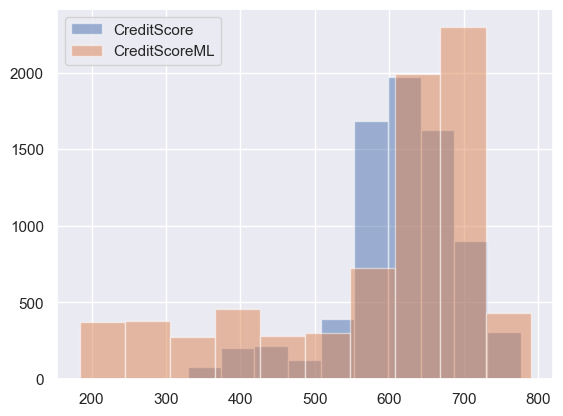

In [113]:
plt.hist(test['CreditScore'], alpha=0.5, label='CreditScore')
plt.hist(test['CreditScoreML'], alpha=0.5, label='CreditScoreML')
plt.legend(loc='upper left')